In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import PowerTransformer
plt.style.use("fivethirtyeight")

In [10]:
train=pd.read_csv("new_train.csv", squeeze=True, parse_dates=["date"])
test=pd.read_csv("new_test.csv", squeeze=True, parse_dates=["date"])

In [11]:
train.head()

,date,temp
0,1980-01-01,4.16
1,1980-02-01,4.06
2,1980-03-01,7.12
3,1980-04-01,9.23
4,1980-05-01,3.20


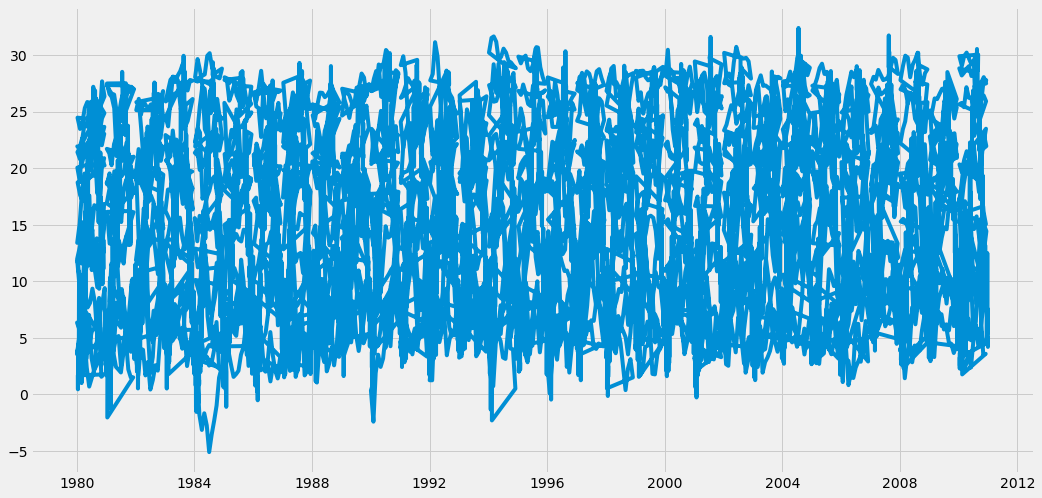

In [17]:
plt.figure(figsize=(16,8))
plt.plot(train["date"],train["temp"])

In [18]:
index=np.random.permutation(len(train))
train=train.loc[index,]

In [19]:
test.head()

0   2011-01-01
1   2011-02-01
2   2011-03-01
3   2011-04-01
4   2011-05-01
Name: date, dtype: datetime64[ns]

In [20]:
test=pd.DataFrame(test)
test.columns=["date"]
test.head()

,date
0,2011-01-01
1,2011-02-01
2,2011-03-01
3,2011-04-01
4,2011-05-01


In [21]:
train.describe()

,temp
count,11323.000000
mean,15.573259
std,7.877191
min,-5.110000
25%,8.390000
50%,15.990000
75%,22.055000
max,32.390000


In [22]:
data=pd.concat((train, test), axis=0)

In [23]:
data["year"]=data["date"].dt.year
data["month"]=data["date"].dt.month
data["week"]=data["date"].dt.week
data["day"]=data["date"].dt.day
data["quar"]=data["date"].dt.quarter

In [24]:
agg_data={
    'temp':['max','min','mean',"std"]}

df = data.groupby(['week']).agg(agg_data)

df.columns=['C_' + '_'.join(col).strip() for col in df.columns.values]
df.reset_index(inplace=True)
df.head()
data=data.merge(df,on='week',how='left')

In [25]:
agg_data={
    'temp':['max','min','mean',"std"]}

df = data.groupby(['day']).agg(agg_data)

df.columns=['A_' + '_'.join(col).strip() for col in df.columns.values]
df.reset_index(inplace=True)
df.head()
data=data.merge(df,on='day',how='left')

In [26]:
agg_data={
    'temp':['max','min','mean',"std"]}

df = data.groupby(['month']).agg(agg_data)

df.columns=['B_' + '_'.join(col).strip() for col in df.columns.values]
df.reset_index(inplace=True)
df.head()
data=data.merge(df,on='month',how='left')

In [27]:
agg_data={
    'temp':['max','min','mean',"std"]}

df = data.groupby(["month",'day']).agg(agg_data)

df.columns=['D_' + '_'.join(col).strip() for col in df.columns.values]
df.reset_index(inplace=True)
df.head()
data=data.merge(df,on=["month",'day'],how='left')

In [28]:
agg_data={
    'temp':['max','min','mean',"std"]}

df = data.groupby(["quar"]).agg(agg_data)

df.columns=['E_' + '_'.join(col).strip() for col in df.columns.values]
df.reset_index(inplace=True)
df.head()
data=data.merge(df,on=["quar"],how='left')

In [29]:
agg_data={
    'temp':['max','min','mean',"std"]}

df = data.groupby(["quar","month","day"]).agg(agg_data)

df.columns=['F_' + '_'.join(col).strip() for col in df.columns.values]
df.reset_index(inplace=True)
df.head()
data=data.merge(df,on=["quar","month","day"],how='left')

In [30]:
to_drop=[]
corr_matrix = data.drop(['temp'],axis=1).corr()
# print(corr_matrix)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper   

to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)

['week', 'quar', 'D_temp_min', 'D_temp_mean', 'E_temp_mean', 'F_temp_max', 'F_temp_min', 'F_temp_mean', 'F_temp_std']


In [31]:
data.drop(to_drop,inplace=True,axis=1)

In [32]:
train=data[~data["temp"].isna()]
test=data[data["temp"].isna()].drop("temp", axis=1)

In [33]:
x=train.drop(["temp","date"], axis=1)
y=train["temp"]

tes=test.drop("date", axis=1)

In [34]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11323 entries, 0 to 11322
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         11323 non-null  int64  
 1   month        11323 non-null  int64  
 2   day          11323 non-null  int64  
 3   C_temp_max   11323 non-null  float64
 4   C_temp_min   11323 non-null  float64
 5   C_temp_mean  11323 non-null  float64
 6   C_temp_std   11323 non-null  float64
 7   A_temp_max   11323 non-null  float64
 8   A_temp_min   11323 non-null  float64
 9   A_temp_mean  11323 non-null  float64
 10  A_temp_std   11323 non-null  float64
 11  B_temp_max   11323 non-null  float64
 12  B_temp_min   11323 non-null  float64
 13  B_temp_mean  11323 non-null  float64
 14  B_temp_std   11323 non-null  float64
 15  D_temp_max   11323 non-null  float64
 16  D_temp_std   11323 non-null  float64
 17  E_temp_max   11323 non-null  float64
 18  E_temp_min   11323 non-null  float64
 19  E_te

In [35]:
x.head()

,year,month,day,C_temp_max,C_temp_min,C_temp_mean,C_temp_std,A_temp_max,A_temp_min,A_temp_mean,A_temp_std,B_temp_max,B_temp_min,B_temp_mean,B_temp_std,D_temp_max,D_temp_std,E_temp_max,E_temp_min,E_temp_std
0,2002,4,13,29.86,4.83,16.578571,6.039145,29.71,-2.31,15.651855,7.842962,31.17,-3.15,15.267731,5.437910,21.04,3.222238,31.17,-3.15,5.925682
1,1990,1,14,30.19,0.78,14.996129,8.333814,29.88,-0.46,15.644435,7.816025,30.21,-2.05,8.905016,7.500472,10.36,2.743823,31.64,-2.42,7.167619
2,1998,1,26,25.76,-2.42,7.247880,5.443651,30.53,-1.56,15.347500,7.919290,30.21,-2.05,8.905016,7.500472,8.13,2.449881,31.64,-2.42,7.167619
3,1997,4,5,31.17,-3.15,15.445714,7.729166,22.69,10.72,17.493629,2.276089,31.17,-3.15,15.267731,5.437910,20.76,2.232831,31.17,-3.15,5.925682
4,1995,7,7,30.56,-5.11,16.549585,7.868261,29.82,17.27,23.998522,2.365359,32.39,-5.11,21.925369,7.249617,29.82,2.453862,32.39,-5.11,7.073511


In [36]:
x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=0.33, random_state=23)

In [37]:
def test_accuracy(models):
    for i in models:
        i.fit(x_train,y_train)
        pred=i.predict(x_test)
        print("{}:{}".format(i,np.sqrt(mean_squared_error(y_test, pred))))

In [38]:
ran=RandomForestRegressor(n_jobs=-1)
grad=GradientBoostingRegressor()
xgb=XGBRegressor()
lgb=LGBMRegressor()
cat=CatBoostRegressor(verbose=200)

In [39]:
models=[xgb, ran, lgb, grad, cat]
test_accuracy(models)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None):2.2382985313770902
RandomForestRegressor(n_jobs=-1):2.3146871870904744
LGBMRegressor():2.192145707734141
GradientBoostingRegressor():2.312213848773541
Learning rate set to 0.055981
0:	learn: 7.4816300	total: 145ms	remaining: 2m 25s
200:	learn: 2.1985557	total: 631ms	remaining: 2.51s
400:	learn: 2.0302167	total: 1.08s	remaining: 1.61s
600:	learn: 1.9129286	total: 1.55s	remaining: 1.03s
800:	learn: 1.8242427	total: 2.01s	re

In [40]:
xgb = XGBRegressor(max_depth=13, n_estimators=100, learning_rate=0.1,min_child_weight=3)
xgb.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)],verbose=200, early_stopping_rounds=200)

[0]	validation_0-rmse:15.30235	validation_1-rmse:15.43549
[99]	validation_0-rmse:0.53613	validation_1-rmse:2.27609


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=13,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [41]:
ypred_xgb = xgb.predict(x_test)
np.sqrt(mean_squared_error(y_test,ypred_xgb))

2.2676537305133904

In [42]:
lgb = LGBMRegressor()
lgb.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test, y_test)],verbose=200, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 3.69937	valid_1's l2: 4.8055


LGBMRegressor()

In [43]:
ypred_lgb = pd.Series(lgb.predict(x_test))
np.sqrt(mean_squared_error(y_test, ypred_lgb))

2.192145707734141

In [44]:
cat = CatBoostRegressor(n_estimators=100,depth=5,learning_rate=0.1)
cat.fit(x_train,y_train,eval_set=[(x_test,y_test)], verbose=200,plot=True)

0:	learn: 7.1878274	test: 7.2502648	best: 7.2502648 (0)	total: 7.08ms	remaining: 701ms


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

99:	learn: 2.2796756	test: 2.3158972	best: 2.3158972 (99)	total: 271ms	remaining: 0us

bestTest = 2.315897226
bestIteration = 99



In [45]:
ypred_cat = cat.predict(x_test)
np.sqrt(mean_squared_error(y_test,ypred_cat))

2.3158972150746653

In [46]:
rf = RandomForestRegressor()
rf.fit(x_train,y_train)

RandomForestRegressor()

In [47]:
ypred_rf=rf.predict(x_test)
np.sqrt(mean_squared_error(y_test,ypred_cat))

2.3158972150746653

In [48]:
cat.fit(x,y, verbose=0)
pred=np.round(pd.Series(cat.predict(tes)),4)

In [49]:
pred=pd.concat((test["date"].reset_index(drop=True),pred),axis=1)
pred.columns=["date","prediction"]

In [50]:
pred

,date,prediction
0,2011-01-01,6.4120
1,2011-02-01,5.6466
2,2011-03-01,6.0434
3,2011-04-01,6.2599
4,2011-05-01,6.0324
...,...,...
3556,2020-09-26,21.2895
3557,2020-09-27,20.4469
3558,2020-09-28,20.2312
3559,2020-09-29,20.6154


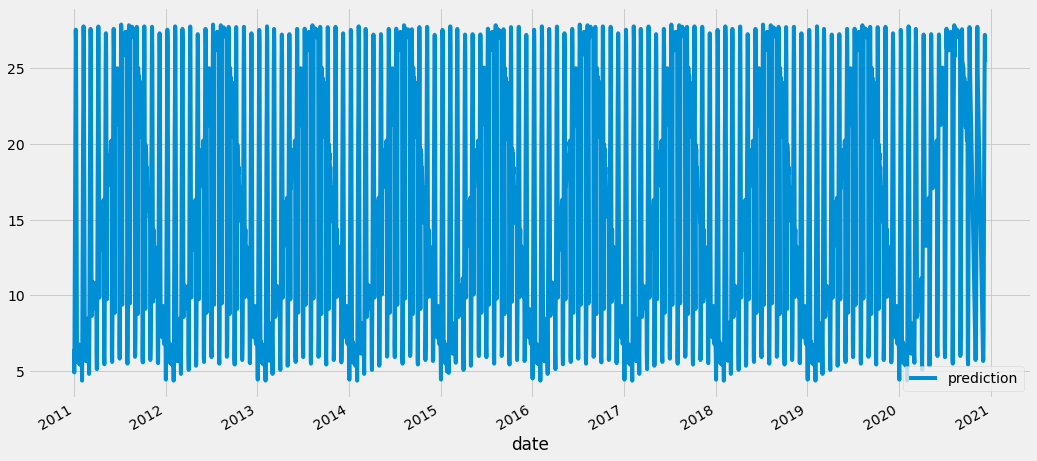

In [52]:
pred.plot(x="date",y="prediction",figsize=(16,8));

In [53]:
pred.drop("date", axis=1,inplace=True)

In [54]:
pred.to_csv("submission.csv", index=False)